In [1]:
import pandas as pd
data = pd.read_csv('data/events_processed.csv')
data['event_time'] = pd.to_datetime(data['event_time'])
print(data.head())

C:\Users\PC\AppData\Local\Temp\ipykernel_20504\3135877037.py:2: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/events_processed.csv')


                 event_time event_type  product_id          category_id  \
0 2020-09-24 11:57:06+00:00       view     1996170  2144415922528452715   
1 2020-09-24 11:57:26+00:00       view      139905  2144415926932472027   
2 2020-09-24 11:57:27+00:00       view      215454  2144415927158964449   
3 2020-09-24 11:57:33+00:00       view      635807  2144415923107266682   
4 2020-09-24 11:57:36+00:00       view     3658723  2144415921169498184   

                   category_code        brand   price              user_id  \
0          electronics.telephone      unknown   31.90  1515915625519388267   
1    computers.components.cooler       zalman   17.16  1515915625519380411   
2                        unknown      unknown    9.81  1515915625513238515   
3  computers.peripherals.printer       pantum  113.81  1515915625519014356   
4                        unknown  cameronsino   15.87  1515915625510743344   

  user_session  year  month  day  quarter  week  weekday  dayofyear  \
0   LJuJV

## Phân tích Customer Retention Rate (Tỷ lệ giữ chân khách hàng)

### 1. Mục tiêu
Phân tích tỷ lệ khách hàng quay lại mua hàng từ lần thứ hai trở đi, nhằm:
- Đo lường mức độ trung thành của khách hàng.
- Hiểu hành vi mua lại: khách hàng thường quay lại sau bao nhiêu ngày.
- Xác định các phân khúc sản phẩm hoặc thời điểm có tỷ lệ giữ chân tốt.

### 2. Định nghĩa KPI
Customer Retention Rate được tính bằng công thức:

$$
\text{Customer Retention Rate} = \frac{\text{Số lượng khách hàng đã mua} \geq 2 \text{ lần}}{\text{Số lượng khách hàng đã mua ít nhất 1 lần}}
$$

Trong đó:
- **Returning Users**: người dùng đã thực hiện từ 2 lần mua trở lên.
- **Purchasing Users**: người dùng đã thực hiện ít nhất 1 lần mua.


#### * Retention là gì?
**Retention** là tỷ lệ khách hàng quay lại sử dụng dịch vụ hoặc mua hàng sau một thời điểm bắt đầu (thường là lần đầu tiên).

- Lưu ý : số lần mua dựa trên só ngày mua khác nhau


### 3. Ý nghĩa kinh doanh
Việc phân tích Customer Retention Rate giúp:
- Đánh giá hiệu quả của sản phẩm và trải nghiệm người dùng.
- Xác định thời điểm thích hợp để thực hiện remarketing, gửi ưu đãi giữ chân khách hàng.
- Ưu tiên các nhóm sản phẩm, thương hiệu, hoặc thời điểm có khả năng tạo giá trị lâu dài cao hơn.


#### Tổng quan về retention rate

In [2]:

purchases = data[data['event_type'] == 'purchase'].copy()
purchases['event_date'] = pd.to_datetime(purchases['event_time']).dt.date

session_dates = (
    purchases
    .groupby(['user_id', 'user_session'])['event_time']
    .min()
    .dt.date
    .reset_index(name='event_date')
)
print(session_dates.head())

# Đếm số ngày mà user có đơn hàng
order_counts = session_dates.groupby('user_id')['event_date'].nunique()

# Tính số lượng người dùng đã đặt hàng ít nhất 1 lần và ít nhất 2 lần
purchasing_users = (order_counts >= 1).sum()
returning_users = (order_counts >= 2).sum()

retention_rate = returning_users / purchasing_users if purchasing_users > 0 else 0

print('----------------------------------------------------------------------------------------------------')
print(f"Retention Rate: {retention_rate:.2%}")

               user_id                          user_session  event_date
0  1515915625353286099                            p5I1h2vk1T  2020-10-03
1  1515915625353457259                            kD2TVJlla1  2020-09-29
2  1515915625353534622                            mNGo9YKWcw  2020-10-06
3  1515915625353561691                            UmL0qYoQh4  2020-11-24
4  1515915625353900095  12dadbda-acb5-4f26-a5e8-f71814190c04  2020-10-15
----------------------------------------------------------------------------------------------------
Retention Rate: 5.60%


### Nhận xét kết quả Customer Retention Rate

Tỷ lệ **5.60%** cho thấy rằng trong số những khách hàng đã từng mua ít nhất một đơn hàng, **chỉ có khoảng 1 trên 18 người** quay lại mua thêm đơn hàng thứ hai trở lên.  
Đây là một **mức retention rất thấp** nếu so sánh với mặt bằng chung trong ngành thương mại điện tử.

Điều này hoàn toàn **phù hợp với đặc thù ngành hàng điện tử tiêu dùng**, với một số đặc điểm sau:

- **Sản phẩm điện tử** như điện thoại, máy tính, thiết bị mạng có **chu kỳ thay thế dài**.
- **Khách hàng không có nhu cầu mua lại ngay**, trừ khi có sự cố hoặc nâng cấp.
- **Giá trị đơn hàng cao**, hành vi tái mua ít phổ biến hơn so với các ngành như FMCG (hàng tiêu dùng nhanh).


Ngoài ra, thời gian thu thập dữ liệu tương đối ngắn (từ tháng 10/2019 đến tháng 2/2020) có thể chưa đủ để quan sát đầy đủ hành vi mua lại của khách hàng.



### Phân tích khoảng thời gian giữa lần mua đầu tiên và lần mua thứ hai

#### Mục tiêu
Xác định số ngày trung bình và trung vị giữa lần mua đầu tiên và lần mua thứ hai của mỗi người dùng.  
Từ đó tìm ra thời điểm tối ưu để thực hiện các chiến dịch chăm sóc khách hàng sau lần mua đầu tiên.

In [3]:
# Lọc các user có ít nhất 2 ngày mua khác nhau
valid_users = (
    session_dates
    .groupby('user_id')['event_date']
    .nunique()
    .loc[lambda x: x >= 2]
    .index
)

multi_purchase_sessions = session_dates[session_dates['user_id'].isin(valid_users)].copy()
print(multi_purchase_sessions.head())

                user_id user_session  event_date
6   1515915625354561351   M4JERvJr9C  2020-09-25
7   1515915625354561351   UhhPeUCUpG  2020-10-02
12  1515915625355398801   58RgY3mnbX  2020-12-01
13  1515915625355398801   8MUVGuak80  2020-10-03
14  1515915625355398801   qnnboVnBIP  2020-10-23


In [4]:
# Với mỗi user, sắp xếp theo ngày và lấy ngày thứ nhất, thứ hai
first_second_purchase = (
    multi_purchase_sessions
    .sort_values(['user_id', 'event_date'])
    .groupby('user_id')['event_date']
    .apply(lambda x: list(x.unique()[:2]))
    .reset_index(name='purchase_dates')
)

# Tính số ngày chênh lệch giữa lần 2 và lần 1
first_second_purchase['days_between'] = first_second_purchase['purchase_dates'].apply(
    lambda x: (x[1] - x[0]).days
)

print(first_second_purchase['days_between'].describe())



count    1192.000000
mean        8.937081
std        14.593521
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       118.000000
Name: days_between, dtype: float64


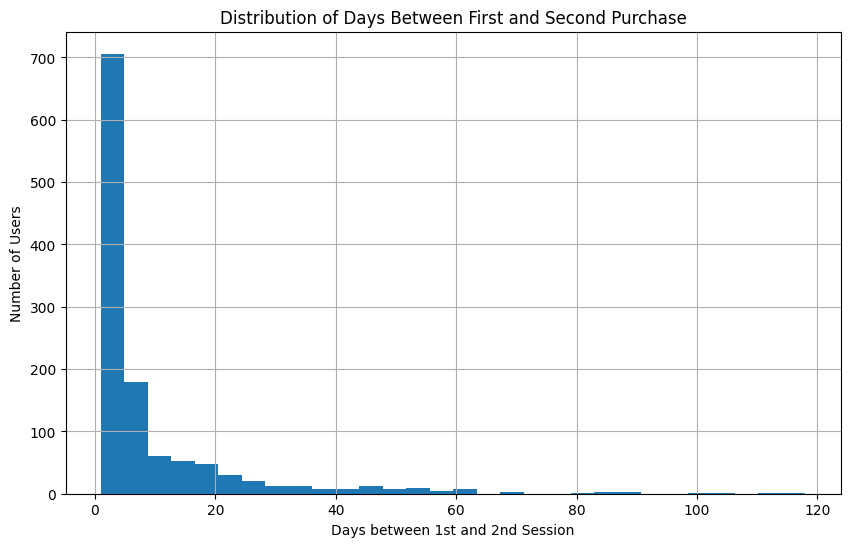

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
first_second_purchase['days_between'].hist(bins=30)
plt.title('Distribution of Days Between First and Second Purchase')
plt.xlabel('Days between 1st and 2nd Session')
plt.ylabel('Number of Users')
plt.grid(True)
plt.show()


### Nhận xét kết quả khoảng thời gian giữa lần mua đầu tiên và lần mua thứ hai

#### 1. Kết quả tổng quan

Sau khi loại bỏ những lần mua có khoảng cách 0 ngày (chỉ giữ khoảng cách > 0 ngày), thống kê cho thấy:

| Thống kê | Giá trị |
|:---|:---|
| Số lượng user (count) | 1192 |
| Thời gian quay lại trung bình (mean) | 8.94 ngày |
| Thời gian quay lại trung vị (50%) | 3 ngày |
| 25% user quay lại trong vòng | 1 ngày |
| 75% user quay lại trong vòng | 9 ngày |
| Thời gian quay lại xa nhất (max) | 118 ngày |

#### 2. Phân tích

Kết quả cho thấy hành vi quay lại mua hàng của khách hàng như sau:
- Trung bình, khách hàng quay lại sau khoảng **9 ngày** kể từ lần mua đầu tiên.
- Tuy nhiên, **50% khách hàng** thực hiện lần mua thứ hai chỉ trong khoảng **3 ngày**.
- 25% khách hàng trung thành nhất thậm chí quay lại chỉ trong **1 ngày**.
- Một số ít khách hàng quay lại sau thời gian rất dài (lên tới **118 ngày**), điều này hợp lý do vòng đời sản phẩm điện tử tiêu dùng dài hơn sản phẩm tiêu dùng nhanh.

Khoảng thời gian từ **1 đến 9 ngày** chiếm phần lớn hành vi quay lại, đây là tín hiệu quan trọng cho việc thiết kế các chiến dịch remarketing.

#### 3. Ý nghĩa thực tiễn

- **Giai đoạn "vàng"** để thực hiện các chiến dịch remarketing hoặc upsell là trong vòng **3–9 ngày** sau lần mua đầu tiên.
- Các chiến dịch nhắc nhở, gửi ưu đãi, hoặc giới thiệu sản phẩm liên quan nên tập trung vào khoảng thời gian này để tối ưu hóa khả năng quay lại mua hàng.
- Cần chú ý thêm phân tích theo từng phân khúc sản phẩm cụ thể để tinh chỉnh chính xác thời điểm tiếp cận.



### Phân tích Cohort Retention theo tháng mua đầu tiên

#### 1. Mục tiêu
Phân tích khả năng giữ chân khách hàng theo từng tháng mua hàng đầu tiên (cohort).
Từ đó đánh giá xem thời điểm user tham gia có ảnh hưởng đến tỷ lệ quay lại hay không.

In [6]:
#Chuyển event_date thành Period tháng
session_dates['session_month'] = pd.to_datetime(session_dates['event_date']).dt.to_period('M')
print(session_dates.head())
print("----------------------------------------------------------------------------------------------------")

#  Xác định cohort_month (tháng mua đầu tiên) cho mỗi user
first_month = (
    session_dates
    .groupby('user_id')['session_month']
    .min()
    .reset_index()
    .rename(columns={'session_month': 'cohort_month'})
)
print(first_month.head())
print("----------------------------------------------------------------------------------------------------")

# Gộp cohort_month vào bảng session_dates
cohort_data = session_dates.merge(first_month, on='user_id')
print(cohort_data.columns)
print(cohort_data[['user_id','session_month', 'cohort_month']].head())


               user_id                          user_session  event_date  \
0  1515915625353286099                            p5I1h2vk1T  2020-10-03   
1  1515915625353457259                            kD2TVJlla1  2020-09-29   
2  1515915625353534622                            mNGo9YKWcw  2020-10-06   
3  1515915625353561691                            UmL0qYoQh4  2020-11-24   
4  1515915625353900095  12dadbda-acb5-4f26-a5e8-f71814190c04  2020-10-15   

  session_month  
0       2020-10  
1       2020-09  
2       2020-10  
3       2020-11  
4       2020-10  
----------------------------------------------------------------------------------------------------
               user_id cohort_month
0  1515915625353286099      2020-10
1  1515915625353457259      2020-09
2  1515915625353534622      2020-10
3  1515915625353561691      2020-11
4  1515915625353900095      2020-10
----------------------------------------------------------------------------------------------------
Index(['user_id',

In [7]:
# Tính khoảng cách (số tháng) giữa session_month và cohort_month
cohort_data['period_number'] = (
    (cohort_data['session_month'].dt.year - cohort_data['cohort_month'].dt.year) * 12 +
    (cohort_data['session_month'].dt.month - cohort_data['cohort_month'].dt.month)
)

# Đếm số user duy nhất theo cohort_month và period_number
cohort_counts = (
    cohort_data
    .groupby(['cohort_month', 'period_number'])['user_id']
    .nunique()
    .reset_index(name='n_users')
)
print(cohort_counts.head())
print("----------------------------------------------------------------------------------------------------")

# Chuyển thành ma trận pivot: mỗi dòng là một cohort_month, cột là period_number
cohort_pivot = cohort_counts.pivot(
    index='cohort_month',
    columns='period_number',
    values='n_users'
).fillna(0).astype(int)

#  Tính retention rate: chia cho cột period 0 (cohort size)
cohort_sizes = cohort_pivot[0]
retention = cohort_pivot.divide(cohort_sizes, axis=0).round(3)

print("Cohort counts:\n", cohort_pivot)
print("----------------------------------------------------------------------------------------------------")
print("\nRetention rate:\n", retention)


  cohort_month  period_number  n_users
0      2020-09              0      627
1      2020-09              1       21
2      2020-09              2        5
3      2020-09              3        2
4      2020-10              0     3772
----------------------------------------------------------------------------------------------------
Cohort counts:
 period_number     0   1   2  3  4
cohort_month                     
2020-09         627  21   5  2  0
2020-10        3772  48  15  3  3
2020-11        4258  48  25  6  0
2020-12        3782  56  20  0  0
2021-01        4673  87   0  0  0
2021-02        4192   0   0  0  0
----------------------------------------------------------------------------------------------------

Retention rate:
 period_number    0      1      2      3      4
cohort_month                                  
2020-09        1.0  0.033  0.008  0.003  0.000
2020-10        1.0  0.013  0.004  0.001  0.001
2020-11        1.0  0.011  0.006  0.001  0.000
2020-12        1.0  0.0

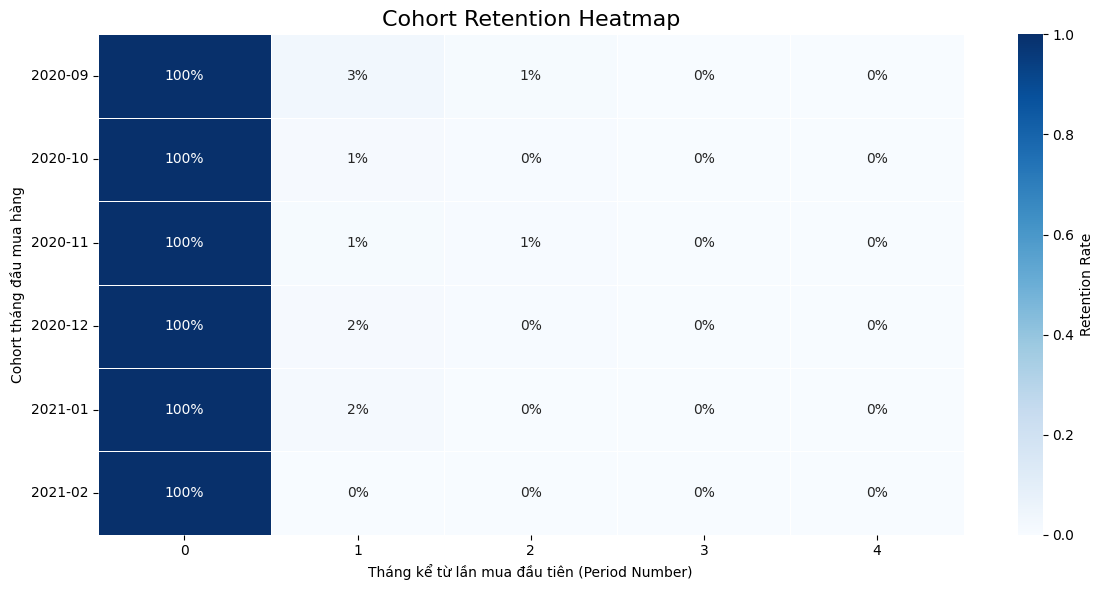

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

retention.index = retention.index.astype(str)
retention.columns = retention.columns.astype(str)

plt.figure(figsize=(12, 6))
sns.heatmap(
    retention,
    annot=True, fmt=".0%", cmap="Blues", linewidths=0.5, linecolor='white',
    cbar_kws={'label': 'Retention Rate'}
)

plt.title("Cohort Retention Heatmap", fontsize=16)
plt.xlabel("Tháng kể từ lần mua đầu tiên (Period Number)")
plt.ylabel("Cohort tháng đầu mua hàng")
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()



### *Nhận xét kết quả Cohort Retention theo tháng mua đầu tiên

#### 1. Kết quả tổng quan

Bảng Retention Rate theo Cohort cho thấy tỷ lệ người dùng quay lại sau tháng đầu tiên như sau:

| Cohort tháng | Month 0 | Month 1 | Month 2 | Month 3 | Month 4 |
|--------------|---------|---------|---------|---------|---------|
| 2020-09      | 100%    | 3.3%    | 0.8%    | 0.3%    | 0.0%    |
| 2020-10      | 100%    | 1.3%    | 0.4%    | 0.1%    | 0.1%    |
| 2020-11      | 100%    | 1.1%    | 0.6%    | 0.1%    | 0.0%    |
| 2020-12      | 100%    | 1.5%    | 0.5%    | 0.0%    | 0.0%    |
| 2021-01      | 100%    | 1.9%    | 0.0%    | 0.0%    | 0.0%    |
| 2021-02      | 100%    | 0.0%    | 0.0%    | 0.0%    | 0.0%    |

#### 2. Phân tích

- **Tỷ lệ giữ chân khách hàng sau tháng đầu tiên (Month 1)** thấp dần theo thời gian:
  - Tháng cao nhất là **2020-09: 3.3%**
  - Tháng thấp nhất là **2021-02: 0.0%**
- Cohort tháng **2020-09** tuy có quy mô nhỏ nhất (627 user) nhưng có tỷ lệ giữ chân cao nhất ở Month 1 (3.3%), cho thấy đây có thể là nhóm khách hàng chất lượng hơn.
- Các cohort mới hơn (2021-01, 2021-02) chưa đủ thời gian để quan sát long-term retention (nhiều giá trị ở các tháng sau vẫn là 0).

#### 3. Kết luận và khuyến nghị

- **Tỷ lệ quay lại tổng thể còn khá thấp**, đa phần dưới 2% từ tháng thứ hai trở đi.
- Các chiến dịch giữ chân khách hàng nên được tập trung thực hiện **ngay trong tháng đầu tiên (Month 0 – Month 1)**.
- Nên xem xét lại các yếu tố ảnh hưởng đến chất lượng người dùng đầu vào (kênh marketing, ưu đãi...) vì cohort 2020-09 hoạt động hiệu quả hơn.
- Cần tiếp tục theo dõi các cohort mới trong tháng tiếp theo để cập nhật chính xác hơn xu hướng dài hạn.




### Phân tích Retention Rate theo nhóm sản phẩm (Category)

#### 1. Mục tiêu
Phân tích tỷ lệ khách hàng quay lại mua hàng lần thứ hai theo từng nhóm sản phẩm (`category`).
Từ đó xác định những nhóm sản phẩm có khả năng giữ chân khách hàng tốt nhất.

In [9]:
print(purchases.dtypes)

event_time              datetime64[ns, UTC]
event_type                           object
product_id                            int64
category_id                           int64
category_code                        object
brand                                object
price                               float64
user_id                               int64
user_session                         object
year                                  int64
month                                 int64
day                                   int64
quarter                               int64
week                                  int64
weekday                               int64
dayofyear                             int64
category                             object
sub_category                         object
sub_sub_category                     object
sub_sub_sub_category                 object
event_date                           object
dtype: object


In [10]:
purchases['event_time'] = pd.to_datetime(purchases['event_time'])
purchases['event_date'] = purchases['event_time'].dt.date

# (mỗi user_session trong 1 category là 1 đơn hàng)
cat_sessions = (
    purchases
    .groupby(['category','user_id','user_session'])['event_date']
    .min()                       # lấy ngày mua đầu tiên của session
    .reset_index()
)
print(cat_sessions.head())
print("----------------------------------------------------------------------------------------------------")

# Đếm số ngày mua khác nhau của mỗi user trong mỗi category
cat_order_counts = (
    cat_sessions
    .groupby(['category','user_id'])['event_date']
    .nunique()                   # số ngày mua khác nhau
    .reset_index(name='n_days')
)
print(cat_order_counts.head())



      category              user_id                          user_session  \
0  accessories  1515915625508240652  ea7ace2c-a65e-44c5-9afd-ad4a414d2c41   
1  accessories  1515915625520197149                            fyVfP2DLjD   
2  accessories  1515915625521555690                            ubKDTsrt5K   
3  accessories  1515915625522564795                            kVQuEjsjdx   
4  accessories  1515915625525827148                            9SQQrKFZkb   

   event_date  
0  2020-10-02  
1  2020-09-27  
2  2020-10-01  
3  2020-10-05  
4  2020-10-14  
----------------------------------------------------------------------------------------------------
      category              user_id  n_days
0  accessories  1515915625508240652       1
1  accessories  1515915625520197149       1
2  accessories  1515915625521555690       1
3  accessories  1515915625522564795       1
4  accessories  1515915625525827148       1


In [11]:
# Tính purchasing users và return users theo category
category_retention = (
    cat_order_counts
    .groupby('category')['n_days']
    .agg(
        purchasing_users   = lambda x: (x >= 1).sum(),
        returning_users= lambda x: (x >= 2).sum()
    )
    .reset_index()
)
print(category_retention)


        category  purchasing_users  returning_users
0    accessories                33                2
1     appliances               554               25
2           auto               628               51
3      computers              9423              634
4   construction               560               33
5   country_yard                18                0
6    electronics              4141              193
7      furniture                75                2
8        jewelry                 4                0
9           kids                 4                1
10      medicine                10                0
11         sport                 2                0
12    stationery              1559               72
13       unknown              4779              175


In [12]:
# Tính Retention Rate
category_retention['retention_rate'] = (
    category_retention['returning_users'] 
    / category_retention['purchasing_users']
)

# Sắp xếp theo retention_rate giảm dần
category_retention = category_retention.sort_values(
    'retention_rate', ascending=False
).reset_index(drop=True)

print(category_retention)

        category  purchasing_users  returning_users  retention_rate
0           kids                 4                1        0.250000
1           auto               628               51        0.081210
2      computers              9423              634        0.067282
3    accessories                33                2        0.060606
4   construction               560               33        0.058929
5    electronics              4141              193        0.046607
6     stationery              1559               72        0.046183
7     appliances               554               25        0.045126
8        unknown              4779              175        0.036619
9      furniture                75                2        0.026667
10  country_yard                18                0        0.000000
11       jewelry                 4                0        0.000000
12      medicine                10                0        0.000000
13         sport                 2              

C:\Users\PC\AppData\Local\Temp\ipykernel_20504\4197070203.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


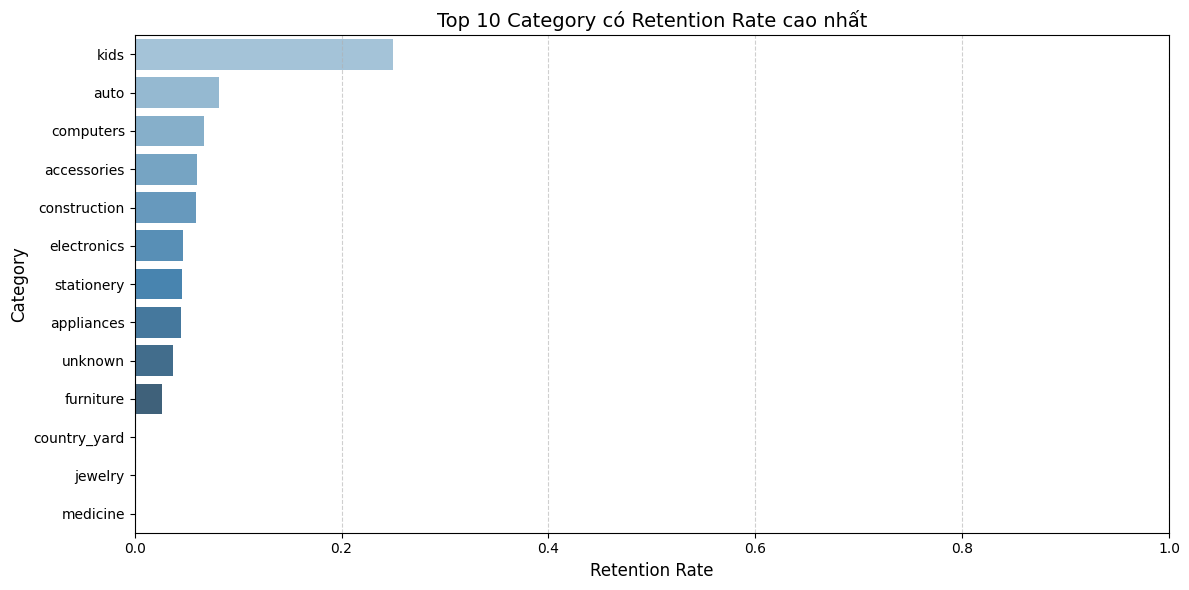

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

# Chọn top 10 category có retention cao nhất
top_categories = category_retention.sort_values('retention_rate', ascending=False).head(13)

sns.barplot(
    data=top_categories,
    x='retention_rate',
    y='category',
    palette='Blues_d'
)

plt.xlabel("Retention Rate", fontsize=12)
plt.ylabel("Category", fontsize=12)
plt.title("Top 10 Category có Retention Rate cao nhất", fontsize=14)
plt.xlim(0, 1)  
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



### * Nhận xét kết quả Retention Rate theo nhóm sản phẩm (Category)

#### 1. Tổng quan

Phân tích tỷ lệ khách hàng quay lại mua hàng lần thứ hai theo từng nhóm sản phẩm (`category`) cho thấy sự chênh lệch rõ rệt giữa các ngành hàng. Dưới đây là bảng top nhóm sản phẩm có tỷ lệ giữ chân cao và thấp:

| Category        | Purchasing Users | Returning Users | Retention Rate |
|----------------|------------------|------------------|----------------|
| kids           | 4                | 1                | 25.00%         |
| auto           | 628              | 51               | 8.12%          |
| computers       | 9423             | 634              | 6.73%          |
| accessories    | 33               | 2                | 6.06%          |
| construction   | 560              | 33               | 5.89%          |
| electronics    | 4141             | 193              | 4.66%          |
| stationery     | 1559             | 72               | 4.62%          |
| appliances     | 554              | 25               | 4.51%          |
| unknown        | 4779             | 175              | 3.67%          |
| furniture      | 75               | 2                | 2.67%          |
| jewelry, sport, medicine, country_yard | Dưới 20 users | 0 returning users | 0.00% |

#### 2. Phân tích

- **Ngành "kids" có tỷ lệ giữ chân cao nhất (25%)**, tuy nhiên **tổng số user chỉ là 4**, nên kết luận này thiếu độ tin cậy thống kê.
- Các ngành có **sample size lớn hơn** như:
  - **Auto (8.12%)**, **Computers (6.73%)**, và **Accessories (6.06%)**
  - Cho thấy khả năng giữ chân khách hàng ở mức khá, đặc biệt **Computers có tới 9423 user**, là nhóm đáng tin cậy nhất về dữ liệu.
- Nhóm **electronics** và **stationery** cũng đạt gần ~4.6%, xếp vào nhóm trung bình.
- Các ngành như **sport, medicine, jewelry, country_yard** có **retention = 0%** nhưng số lượng người dùng cực thấp → **không đủ cơ sở phân tích**.

#### 3. Kết luận & khuyến nghị

- **Computers và Auto** là những ngành có **tỷ lệ quay lại ổn định với lượng user đủ lớn** → Nên đầu tư remarketing, upsell tại các nhóm này.
- Nhóm **electronics và appliances** cần được thúc đẩy thêm vì có thị trường tiềm năng nhưng tỷ lệ quay lại còn thấp.


---

## * Kết luận tổng quan (Retention rate)

### 1. Những điểm chính rút ra từ phân tích

| Nội dung | Nhận xét |
|----------|----------|
| **Tỷ lệ khách quay lại (Retention)** | Chỉ khoảng **5.6% khách quay lại mua lần thứ hai**, tức trung bình **chỉ 1 trong 18 người quay lại**. |
| **Thời gian quay lại** | **50% khách quay lại trong vòng 3 ngày**, trung bình là **9 ngày** → thời gian này rất quan trọng để giữ chân họ. |
| **Nhóm khách theo tháng** | Khách hàng mua lần đầu trong tháng **09/2020 có tỉ lệ quay lại cao nhất** (3.3% trong tháng tiếp theo). |
| **Theo nhóm sản phẩm** | Các ngành như **máy tính (6.7%)** và **ô tô – phụ kiện (8.1%)** giữ chân khách hàng tốt nhất. Nhiều ngành khác rất thấp. |



### 2. Vì sao khách hàng không quay lại nhiều?

- **Sản phẩm điện tử thường đắt tiền và dùng lâu**, nên khách không có nhu cầu mua thêm sớm.
- **Doanh nghiệp chưa chăm sóc khách sau khi mua**, đặc biệt trong **3 ngày đầu tiên**.
- **Chất lượng khách hàng đầu vào chưa ổn định**, có tháng hiệu quả, có tháng thì không.
- **Một số sản phẩm không được hỗ trợ mua thêm**, như phụ kiện, bảo hành, combo…



### 3. Đề xuất hành động cụ thể

| Mức độ | Việc nên làm | Mục tiêu |
|--------|--------------|----------|
| **Trước mắt (0–3 tháng)** | Gửi email/sms sau 1–3 ngày kèm ưu đãi phụ kiện (đặc biệt nhóm máy tính, ô tô) | Tăng tỷ lệ khách quay lại sớm |
| | Hiển thị gợi ý mua phụ kiện ngay sau khi đặt hàng | Tăng tỷ lệ mua kèm |
| **Trung hạn (3–6 tháng)** | Xây chương trình tích điểm đổi quà hoặc ưu đãi bảo hành dài hơn | Khuyến khích mua lặp lại |
| | Lặp lại chiến dịch quảng cáo hiệu quả như tháng 09/2020 | Tăng chất lượng khách mới |
| **Lâu dài (6–12 tháng)** | Phân tích thói quen mua hàng để cá nhân hóa gợi ý sản phẩm | Tăng doanh số dài hạn |
| | Gộp các ngành có ít người mua vào nhóm lớn hơn, hoặc loại bỏ khỏi chiến dịch | Tiết kiệm chi phí tiếp thị |



### 4. Cách theo dõi hiệu quả

- Tạo bảng theo dõi tỷ lệ quay lại theo **tháng đầu mua** và **nhóm sản phẩm** (cập nhật mỗi tuần).
- Sau 1 tháng áp dụng các chiến dịch trên:
  - Kỳ vọng tăng tỷ lệ quay lại sớm từ **5.6% → ít nhất 8%**.
  - Tăng tỷ lệ quay lại sau 7 ngày từ **~1.3% → 3%**.
- Mỗi quý xem xét hiệu quả quảng cáo và điều chỉnh cách tiếp cận khách hàng mới.



>  **Tóm lại:** Doanh nghiệp nên chăm sóc khách **trong 1–9 ngày đầu sau mua**, tập trung vào các ngành hàng như **máy tính và ô tô**, vì đây là nhóm có khả năng quay lại cao nhất.

